<a href="https://colab.research.google.com/github/naphatsiri/DADS-InClass-Master-Degree/blob/main/dads6003_week11_Pytorch_NIDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# https://bit.ly/3CbrI8K

# Google Colab & Google Drive

In [ ]:
!nvidia-smi

In [ ]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

# Basic CNN for MNIST dataset

In [ ]:
import torch
import torchvision

In [ ]:
batch_size_train = 64
batch_size_test = 1000

train_dataset = torchvision.datasets.MNIST(
    '/files/', train=True, download=True,
    transform=torchvision.transforms.Compose([
        # torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,))
    ]))
train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=batch_size_train, shuffle=True)

test_dataset = torchvision.datasets.MNIST(
    '/files/', train=False, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,))
    ]))
test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=batch_size_test, shuffle=False)

In [ ]:
(example_data, example_targets) = test_dataset[3]

In [ ]:
example_data.shape, example_targets

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(example_data[0], cmap='gray')
plt.title("Ground Truth: {}".format(example_targets))
plt.show()

In [ ]:
import matplotlib.pyplot as plt

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)


fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Building Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)  # input 1 channel, 8 filters = output 8 channels, output same size as input
        self.conv2 = nn.Conv2d(8, 10, kernel_size=3, padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(490, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # (batch_size, 1, 28,28) -> conv1 -> (batch_size, 8, 28,28) -> max_pool2d -> (batch_size, 8, 14, 14)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # (batch_size, 8, 14,14) -> conv2 -> (batch_size, 10, 14,14) -> dropout -> (batch_size, 10, 14,14) -> max_pool2d -> (batch_size, 10, 7,7)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # "flatten" >> arrange all values on the feature maps as a single vector >> 490 values
        x = x.view(-1, x.size(dim=1)*x.size(dim=2)*x.size(dim=3))

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [ ]:
model = CNN()

x = torch.rand((1,1,28,28))
model(x).argmax()

In [ ]:
import tqdm

def train_epoch(model, optimizer, data_loader, device):

  model.train()
  model.to(device)
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar := tqdm.tqdm_notebook(data_loader)):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()

    output = model(data)              # predict output for current data
    loss = F.nll_loss(output, target) # compute loss
    loss.backward()                   # backprop to get gradient

    optimizer.step()                  # update the model

    train_loss += loss

    if (batch_idx+1) % 100 == 0:
      pbar.set_description('Train Epoch: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        batch_idx * len(data), len(data_loader.dataset),
        100. * batch_idx / len(data_loader), loss.item()))

  return train_loss

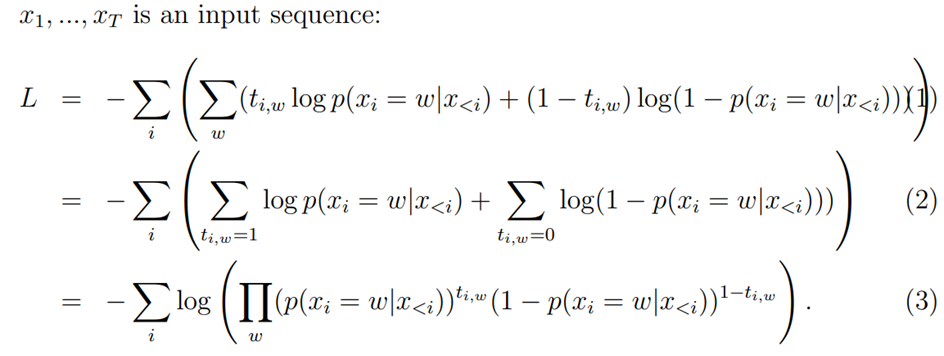

In [ ]:
def test(model, data_loader, device):
  model.eval()
  model.to(device)
  test_loss = 0
  correct = 0
  with torch.no_grad(): # no need for gradient >>not allocate additional variables
    for data, target in data_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(data_loader.dataset)
  test_acc = 100. * correct / len(data_loader.dataset)
  return test_acc, test_loss

In [ ]:
from tqdm import trange

network = CNN()

# training config
n_epochs = 3
learning_rate = 0.01

optimizer = optim.Adam(network.parameters(), lr=learning_rate)

best_acc = 0
for epoch in (pbar := trange(1, n_epochs + 1)):
  train_epoch(network, optimizer, train_loader, device)
  test_acc, test_loss = test(network, test_loader, device)
  if test_acc > best_acc:
    pbar.set_description('Test accracy improves from {:.2f} to {:.2f}'.format(best_acc, test_acc))
    best_acc = test_acc

    torch.save(network.state_dict(), 'model.pth')
    torch.save(optimizer.state_dict(), 'optimizer.pth')

## Train with custom Dataset

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
class MyDataset(Dataset):

    def __init__(self):
        self.dataset = train_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        bitmap, cls = self.dataset[idx]

        return {
            "pixels": torch.tensor(bitmap),
            "label": cls
        }

In [ ]:
train_dataset = MyDataset()
train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=batch_size_train, shuffle=True)

In [ ]:
import tqdm

model = CNN()
#model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)


train_loss = 0
for batch_idx, data in enumerate(pbar := tqdm.tqdm_notebook(train_loader)):
  data, target = data["pixels"], data["label"]

  optimizer.zero_grad()

  output = model(data)              # predict output for current data
  loss = F.nll_loss(output, target) # compute loss
  loss.backward()                   # backprop to get gradient

  optimizer.step()                  # update the model

  train_loss += loss

  if (batch_idx+1) % 100 == 0:
    pbar.set_description('Train Epoch: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      batch_idx * len(data), len(train_loader.dataset),
      100. * batch_idx / len(train_loader), loss.item()))


## Use pre-trained vision model

In [ ]:
!pip install timm

In [ ]:
from timm.models import create_model

In [ ]:
import timm

for i,n in enumerate(timm.list_models('*')):
  print(i, n)

In [ ]:
for i,n in enumerate(timm.list_models('*', pretrained=True)):
  print(i,n)

In [ ]:
model = timm.create_model('resnet50d', pretrained=True)

In [ ]:
model

In [ ]:
# it's possible to adapt existing model for different input channels
# useful when we want to retrain the model on grayscale images
model = timm.create_model('resnet50d', pretrained=True, in_chans=1)

x = torch.rand((1,1,224,224)) # batch, channels, height, width

model(x).size()

In [ ]:
import timm

model = timm.create_model('resnet50d', pretrained=True)
model

In [ ]:
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
transform

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import requests

url = "https://farm1.staticflickr.com/15/18770229_42b4101aa0_z.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
plt.imshow(image)

In [ ]:
input_tensor = transform(image)

In [ ]:
import torchvision.transforms as T

tr = T.ToPILImage()

plt.imshow(tr(input_tensor))

In [ ]:
tr = T.Compose([
    T.Resize(size=256),
    T.CenterCrop(size=(224, 224)),
])

img = tr(image)

plt.imshow(img)

In [ ]:
out = model(input_tensor.unsqueeze(0))
out.topk(10, dim=1)

In [ ]:
# adapt pretrained model to custom data
import timm

custom_model = timm.create_model('resnet50d', pretrained=True, num_classes=14)
custom_model

## Explainability: GradCAM

In [ ]:
!pip install grad-cam

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


In [ ]:
cam = GradCAM(model=model, target_layers=[model.layer4[-1]])

grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=[ClassifierOutputTarget(180)])

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(np.asarray(img)/255, grayscale_cam, use_rgb=True)
visualization

In [ ]:
import timm

model = timm.create_model('deit_tiny_patch16_224', pretrained=True)
transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
transform

In [ ]:
tr = T.Compose([
    T.Resize(size=248),
    T.CenterCrop(size=(224, 224)),
])

img = tr(image)

plt.imshow(img)

In [ ]:
model

In [ ]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [ ]:
cam = GradCAM(model=model, target_layers=[model.blocks[-1].norm1], reshape_transform=reshape_transform)

grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=[ClassifierOutputTarget(180)])

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(np.asarray(img)/255, grayscale_cam, use_rgb=True)
visualization

# NLP

## Pipeline

In [ ]:
from transformers import pipeline

In [ ]:
classifier = pipeline("text-classification", device="cuda") # default model for sentiment analyis

text = """Dear Amazon, last week I ordered an Optimus Prime action figure \
from your online store in Germany. Unfortunately, when I opened the package, \
I discovered to my horror that I had been sent an action figure of Megatron \
instead! As a lifelong enemy of the Decepticons, I hope you can understand my \
dilemma. To resolve the issue, I demand an exchange of Megatron for the \
Optimus Prime figure I ordered. Enclosed are copies of my records concerning \
this purchase. I expect to hear from you soon. Sincerely, Bumblebee."""

import pandas as pd

output = classifier(text)
pd.DataFrame(output)

In [ ]:
ner_tagger = pipeline("ner", aggregation_strategy="simple", device="cuda")
outputs = ner_tagger(text)
pd.DataFrame(outputs)

In [ ]:
reader = pipeline("question-answering", device="cuda")
question = "What does the customer want?"
outputs = reader(question=question, context=text)
pd.DataFrame([outputs])

In [ ]:
summarizer = pipeline("summarization", device="cuda")
outputs = summarizer(text, max_length=60, clean_up_tokenization_spaces=True)
print(outputs[0]["summary_text"])

In [ ]:
generator = pipeline("text-generation")
response = "Dear Bumblebee, I am sorry to hear that your order was mixed up."

prompt = text + "\n\nCustomer service response:\n" + response

outputs = generator(prompt, max_length=200)
print(outputs[0]["generated_text"])

In [ ]:
# A100
translator = pipeline("translation", model="google/madlad400-3b-mt", device="cuda")

In [ ]:
outputs = translator("<2th> " + text, max_length=400)
print(outputs[0]['translation_text'])

In [ ]:
vqa_model = pipeline("visual-question-answering")
image_url = "https://huggingface.co/datasets/Narsil/image_dummy/raw/main/lena.png"
vqa_model(question="What is she wearing ?", image=image_url)

In [ ]:
captioner = pipeline("image-to-text", device="cuda")
captioner("https://huggingface.co/datasets/Narsil/image_dummy/raw/main/lena.png")

In [ ]:
caption = captioner("https://huggingface.co/datasets/Narsil/image_dummy/raw/main/lena.png")

outputs = translator("<2th> " + caption[0]["generated_text"], max_length=400)
print(outputs[0]['translation_text'])

### Hugging Face components
- Models
- Tokenizers
- Datasets
- Metrics


## Wongnai Reviews

In [ ]:
!pip -q install datasets

In [ ]:
!pip install -q emoji pythainlp sefr_cut tinydb seqeval sentencepiece pydantic jsonlines
!pip install --no-deps thai2transformers==0.1.2

In [ ]:
from datasets import load_dataset
dataset = load_dataset('wongnai_reviews')
dataset

In [ ]:
dataset["train"][0]

In [ ]:
from transformers import AutoTokenizer, BertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")
model = BertForSequenceClassification.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")

In [ ]:
#pipeline
from transformers import pipeline

classify_multiclass = pipeline(task='text-classification', tokenizer=tokenizer, model=model, device="cuda")

In [ ]:
# WangchanBERTa official Colab uses this stuff
from thai2transformers.preprocess import process_transformers
input_text = process_transformers(dataset["train"][3]['review_body'])
input_text

In [ ]:
# We need this to handle long text
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':416}

#infer
outputs = classify_multiclass(input_text, **tokenizer_kwargs)

import pandas as pd
pd.DataFrame(outputs)

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "airesearch/wangchanberta-base-att-spm-uncased",
    num_labels=5,
    problem_type="single_label_classification" # "multi_label_classification"
)

In [ ]:
model

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
from datasets import load_dataset
class MyDataset(Dataset):

    def __init__(self):
        self.dataset = dataset["train"]
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        item = self.dataset[idx]
        text = item["review_body"]
        tok  = self.tokenizer(text, max_length=128, padding="max_length", truncation=True, return_tensors="pt")

        return {
            "tok": tok["input_ids"][0],
            "label": item["star_rating"]
        }

In [ ]:
train_dataset = MyDataset()
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

from tqdm import tqdm

for epoch in range(1):

  model.train(True)
  for t,batch in enumerate(train_dataloader):
      optimizer.zero_grad()

      out = model(
          input_ids = batch["tok"],
          labels = batch["label"])

      out.loss.backward()

      optimizer.step()
      if (t+1)%100==0:
        print(".", end="", flush=True)

      if t>=20:
        break

__Hugging Face__ has its own _Trainer_ class which offers several advantages over basic training used above.